# Esercizio serie storica  

Questo secondo esercizio richiede di effettuare un'analisi di dati di serie storica.

Leggendo il dataset data/globaltemperatures.csv, caricare i dati della media della temperatura nei diversi mesi dell'anno dal 1750. Plottare la serie dati, analizarne le caratteristiche (tendenza e stagionalità) e provare a fare una regressione lineare del trend (per valutarne la tendenza). Per fare regressione lineare di una timeseries è conveniente trasformare l'indice (l'asse X) in un numero che indica il numero di periodi passati dal momento inziale.

Infine provare a usare la serie storica per produrre le temperature dei successivi 10 anni.

In [27]:
import pandas as pd
import sys
import os 
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm



sys.path.append('../')

In [28]:
data = pd.read_csv('data/globaltemperatures.csv', parse_dates=['dt'], index_col='dt')
data = data[['LandAverageTemperature']]

## Rappresentazione delle serie storica

In [29]:
plt.rcParams.update({'figure.figsize': (100, 10)})

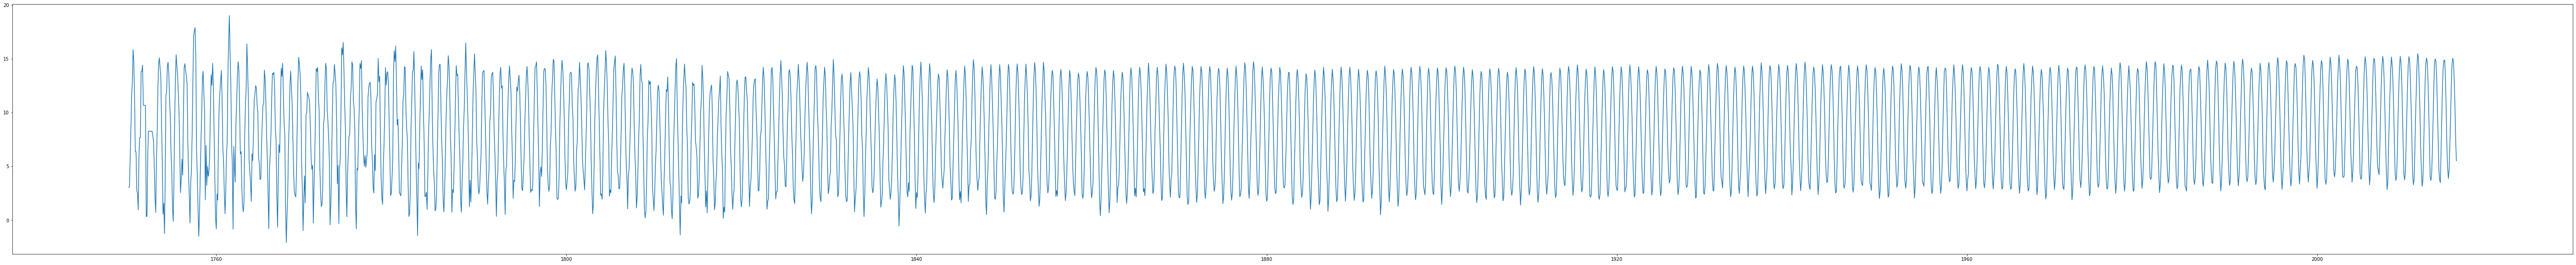

In [183]:
plt.figure(figsize=(100,10))
plt.plot(data.index, data.values)
plt.show()

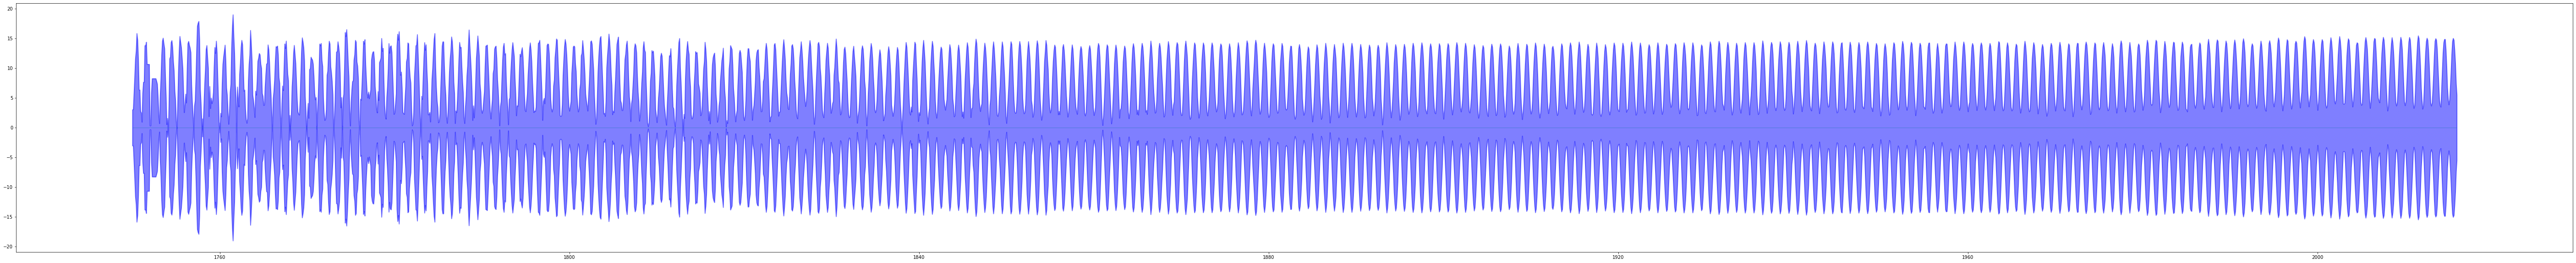

In [185]:
plt.fill_between(data.index, y1=np.array(data.LandAverageTemperature), \
                 y2=np.array(-data.LandAverageTemperature), alpha=0.5, linewidth=2, color='blue')
plt.hlines(y=0, xmin=np.min(data.index), xmax=np.max(data.index), linewidth=.5)
plt.show()

### Gestione dei valori nulli

In [31]:
data_missing = data[data['LandAverageTemperature'].isnull()]
print("L'intervallo temporale dei valori nulli va dal " + str(data_missing.index.min()) + " al " + str(data_missing.index.max()) 
      + ".\nSi riportano i valori nulli \n" + str(data_missing.head(15).reset_index()))

L'intervallo temporale dei valori nulli va dal 1750-11-01 00:00:00 al 1752-09-01 00:00:00.
Si riportano i valori nulli 
           dt  LandAverageTemperature
0  1750-11-01                     NaN
1  1751-05-01                     NaN
2  1751-07-01                     NaN
3  1751-10-01                     NaN
4  1751-11-01                     NaN
5  1751-12-01                     NaN
6  1752-02-01                     NaN
7  1752-05-01                     NaN
8  1752-06-01                     NaN
9  1752-07-01                     NaN
10 1752-08-01                     NaN
11 1752-09-01                     NaN


Per fillare i valori nulli si è deciso si usare la tecnica classica **Forward Fill**. Questa tecnica prevede l'inserimento dell'ultimo valore disponibile per tutti i valori nulli, verrà propagato l'ultima osservazione valida per tutti i valori nulli

La funzione Pandas dataframe.ffill() viene utilizzata per riempire il valore mancante nel dataframe. 'ffill' sta per 'riempimento in avanti' e propagherà l'ultima osservazione valida in avanti.

https://www.geeksforgeeks.org/python-pandas-dataframe-ffill/

In [32]:
data = data.ffill()

## Caratteristiche della serie storica (tendenza, stagionalità e stazionarietà)

### scomposizione delle serie storica

#### Additive Decomposition 
yt = Tt + St+ Et

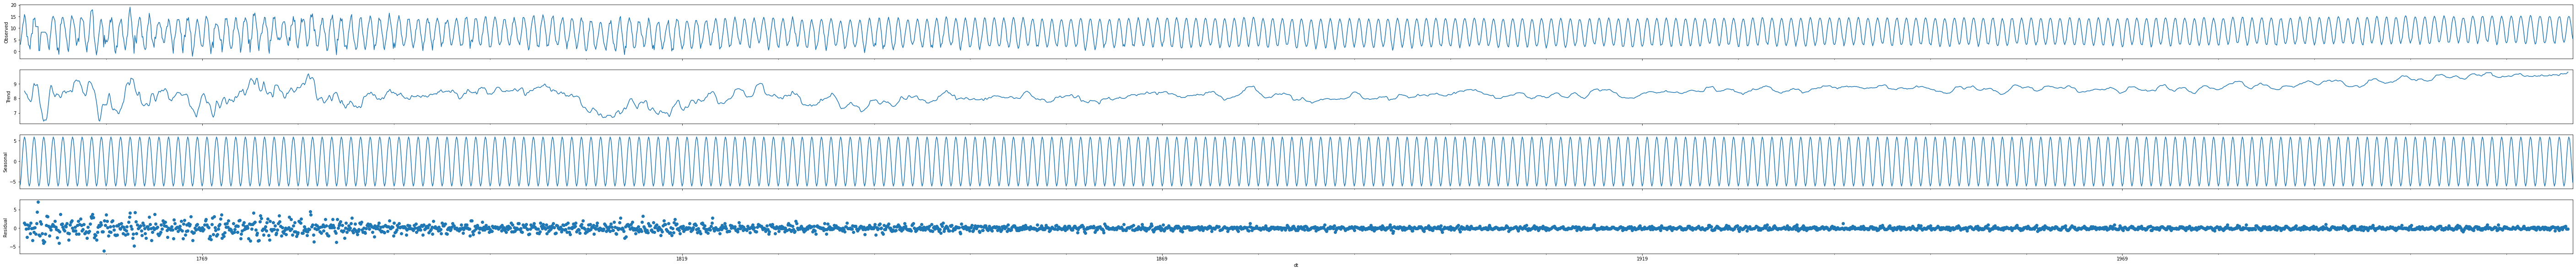

In [33]:

result_add = seasonal_decompose(data['LandAverageTemperature'], model='additive')

# Plot
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(100,10))
result_add.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_add.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_add.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_add.resid.plot(ax=axes[3], legend=False, style='o')
axes[3].set_ylabel('Residual')
plt.show()

####  Multiplicative Decomposition

Non è stato possobile usare l'approccio multiplativo yt = Tt  x  St x Et perché sono presenti dei valori negativi nella serie

#### detrended

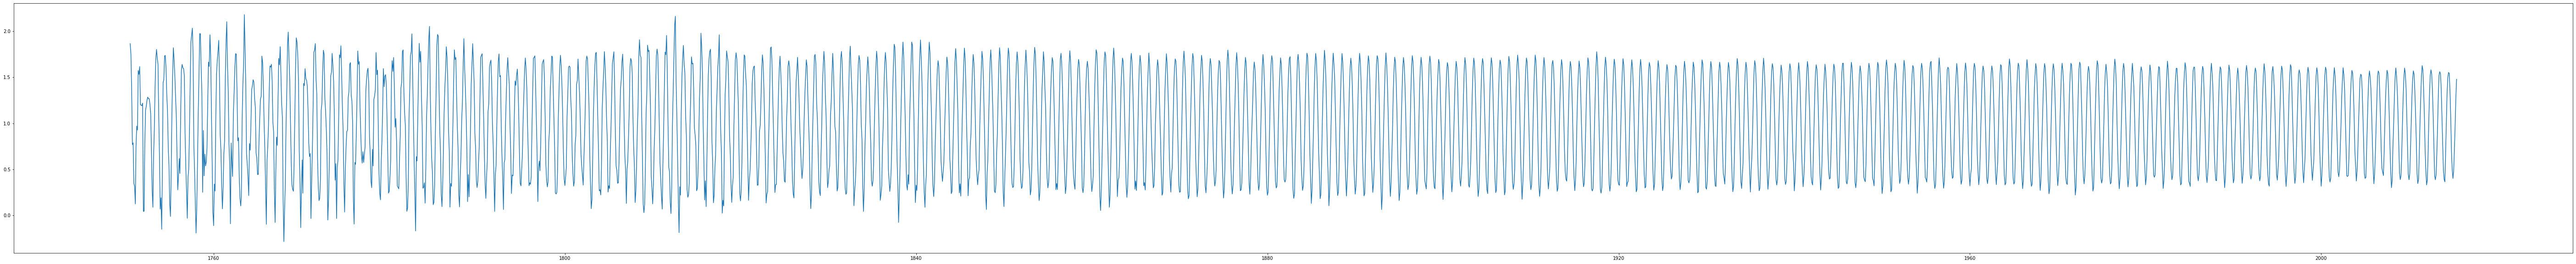

In [34]:
detrended = data.LandAverageTemperature.values / result_add.trend

plt.plot(data.index, detrended)
plt.show()

#### deseasonalized

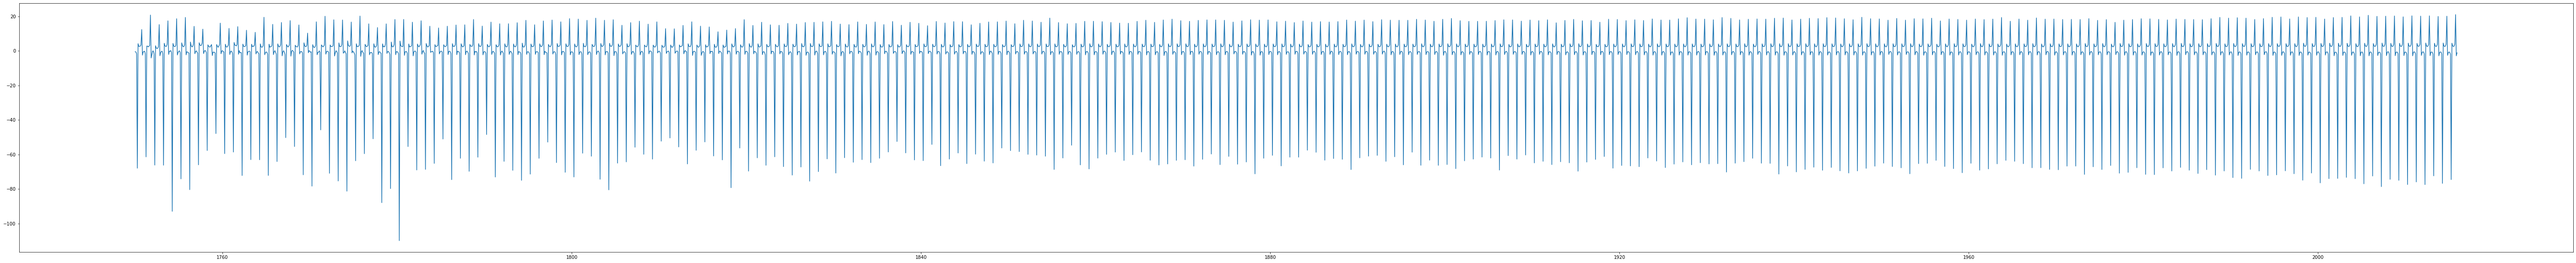

In [35]:
deseasonalized_add = data.LandAverageTemperature.values / result_add.seasonal

plt.plot(data.index, deseasonalized_add)
plt.show()

#### deseasoned_detrended

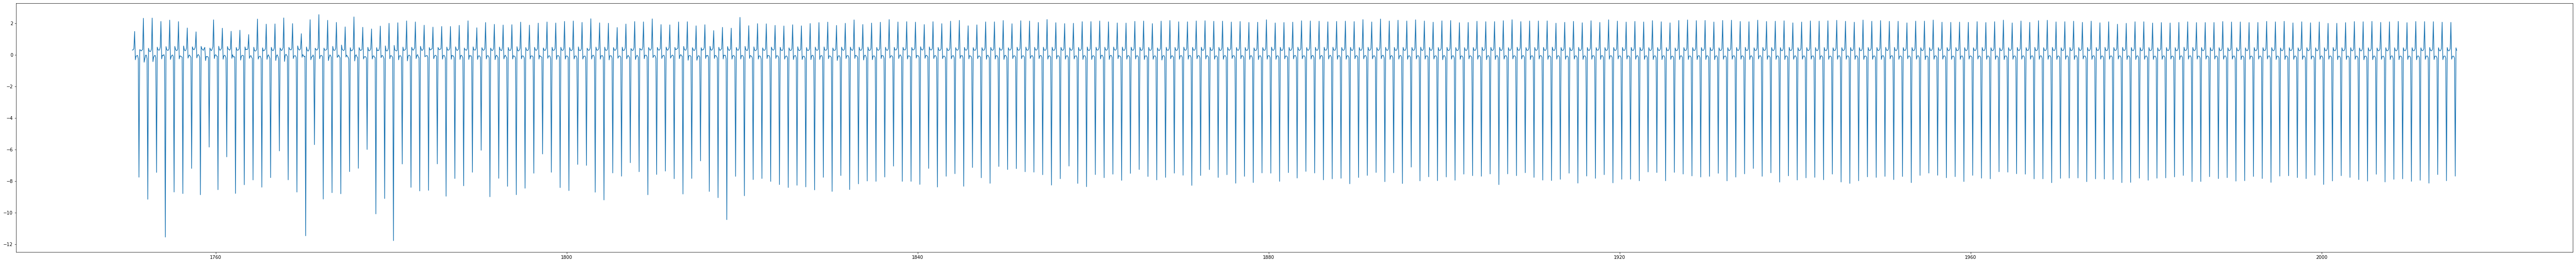

In [36]:
deseasoned = data.LandAverageTemperature.values / result_add.seasonal
deseasoned_detrended = deseasoned / result_add.trend

plt.plot(data.index, deseasoned_detrended)
plt.show()

In [37]:
new_df = data.copy()

new_df['add_detrended'] = detrended
new_df['deseasonalized_add'] = deseasonalized_add
new_df['deseasoned_detrended_add'] = deseasoned_detrended

new_df

LandAverageTemperature  add_detrended  deseasonalized_add  \
dt                                                                      
1750-01-01                   3.034            NaN           -0.497432   
1750-02-01                   3.083            NaN           -0.568783   
1750-03-01                   5.626            NaN           -1.646256   
1750-04-01                   8.490            NaN          -67.937191   
1750-05-01                  11.573            NaN            4.202532   
...                            ...            ...                 ...   
2015-08-01                  14.755            NaN            2.750053   
2015-09-01                  12.999            NaN            3.898149   
2015-10-01                  10.801            NaN           21.033667   
2015-11-01                   7.433            NaN           -2.843309   
2015-12-01                   5.518            NaN           -1.070806   

            deseasoned_detrended_add  
dt                                    
1750-01-01                       NaN  
1750-02-01                       NaN  
1750-03-01                       NaN  
1750-04-01                       NaN  
1750-05-01                       NaN  
...                              ...  
2015-08-01                       NaN  
2015-09-01                       NaN  
2015-10-01                       NaN  
2015-11-01                       NaN  
2015-12-01                       NaN  

[3192 rows x 4 columns]

#### Stazionarietà 

In [38]:
new_df = data.copy()

new_df['LandAverageTemperature'] = deseasonalized_add

result = adfuller(new_df.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.713086
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


## Regressione lineare

Trasformiamo il valore datetime in un indicatore che conta il numero di periodo passati dal giorno disponibile.  

__1 periodo = 1 giorno__

### Preparazione del dato

##### Creazione dei periodi

In [39]:
data.index.min()

Timestamp('1750-01-01 00:00:00')

In [40]:
diff = []
for index, row in data.reset_index().iterrows():
    diff.append((row['dt']- data.reset_index()['dt'].min()).days)
data_regr = data.reset_index().drop(columns='dt')
data_regr['periods'] = diff
data_regr = data_regr.set_index('periods')

In [41]:
y = data_regr['LandAverageTemperature']
x1 = data_regr.index

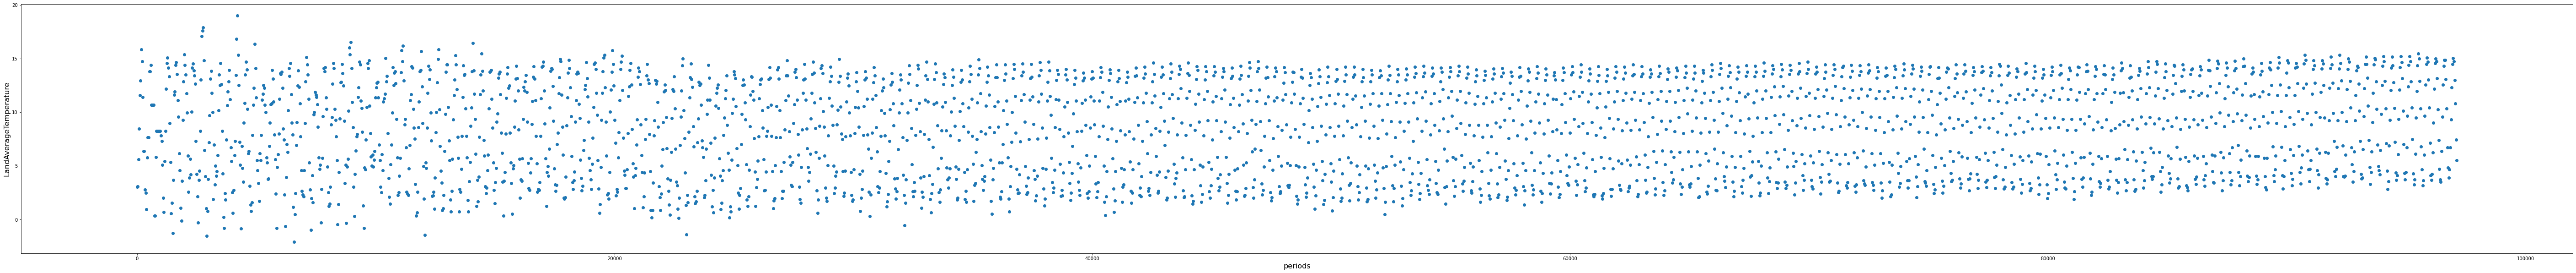

In [42]:
# Plot a scatter plot (first we put the horizontal axis, then the vertical axis)
plt.scatter(x1, y)
# Name the axes
plt.xlabel('periods', fontsize=16)
plt.ylabel('LandAverageTemperature', fontsize=16)
# Show the plot
plt.show()

##### Split del train e del test

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x1, y, test_size=0.3)

##### Aggiunta della costante

In [44]:

# Add a constant. Essentially, we are adding a new column (equal in lenght to x), which consists only of 1s
x = sm.add_constant(X_train)

### Fit del modello

In [45]:
# Fit the model, according to the OLS (ordinary least squares) method with a dependent variable y and an idependent x
results = sm.OLS(Y_train, x).fit()
Y_pred_train = results.predict(x) # eseguiamo la predizione sul train set
Y_pred_test = results.predict(sm.add_constant(X_test)) # eseguiamo la predizione anche sul test set

### Rappresentazione grafica della regressione

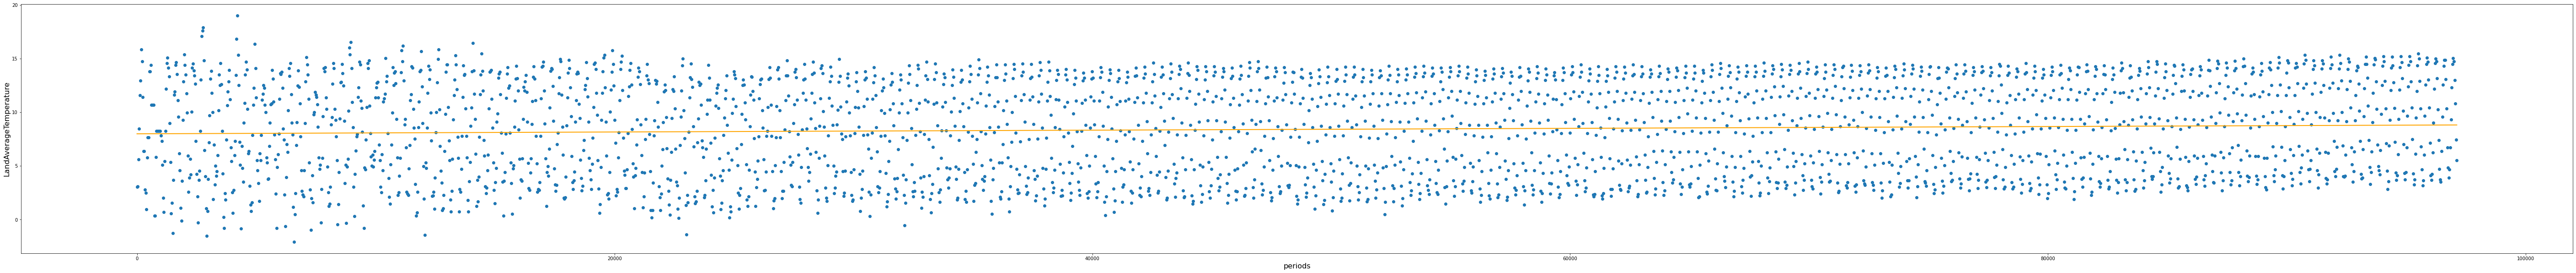

In [46]:
# Create a scatter plot
plt.scatter(x1, y)
# Define the regression equation, so we can plot it later
yhat = results.params.const + results.params.x1 * x1
# Plot the regression line against the independent variable (SAT)
plt.plot(x1, yhat, lw=2, c='orange')
# Label the axes
plt.xlabel('periods', fontsize=16)
plt.ylabel('LandAverageTemperature', fontsize=16)
plt.show()

### Valutazione del modello

#####  mean squared error

In [47]:
from sklearn.metrics import mean_squared_error

print("MSE train: %f" % mean_squared_error(Y_train, Y_pred_train))
print("MSE test: %f" % mean_squared_error(Y_test, Y_pred_test))

MSE train: 19.099618
MSE test: 18.904405


##### r2_score

In [48]:
from sklearn.metrics import r2_score

print("R2 train: %f" % r2_score(Y_train, Y_pred_train))
print("R2 test: %f" % r2_score(Y_test, Y_pred_test))

R2 train: 0.002965
R2 test: 0.012296


In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.003
Model:                                OLS   Adj. R-squared:                  0.003
Method:                     Least Squares   F-statistic:                     6.637
Date:                    Wed, 13 Jul 2022   Prob (F-statistic):             0.0101
Time:                            13:24:34   Log-Likelihood:                -6464.7
No. Observations:                    2234   AIC:                         1.293e+04
Df Residuals:                        2232   BIC:                         1.294e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9952      0.184     43.396      0.000       7.634       8.356
x1            8.5e-06    3.3e-06      2.576      0.010    2.03e-06     1.5e-05
==============================================================================
Omnibus:                    11495.692   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.099
Skew:                          -0.095   Prob(JB):                     8.55e-37
Kurtosis:                       1.678   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Possiamo ricavare la funzione che sarà così composta  

$ y = 7.8656 + 1.187e^{-05} * periods  $

E' però necessario considerare le metriche per valuare il modello. Entrambe non hanno evendenziato valori risultati positivi sulla regressione lineare appena compiuta.  
L'**r2 score** nello specifico presenta valori inferiori allo 0.3, questo ci indica che il modello può essere ritenuto non affidabile.


## Forecasting di una serie storica

In [172]:
data.index.min(), data.index.max()

(Timestamp('1750-01-01 00:00:00'), Timestamp('2015-12-01 00:00:00'))

Dunque il nostro obiettivo sarà quello di prevedere 10 anni di temperature del suolo da dal 2015-12-01 al 2025-12-01

### Addestramento del modello con auto arima

In [54]:
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9705.289, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8523.799, Time=4.75 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9703.352, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=9333.608, Time=0.27 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8250.071, Time=10.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=21.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.69 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8660.241, Time=5.42 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8244.380, Time=11.00 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8519.039, Time=3.81 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=39.41 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=18.74 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3192
Model:             SARIMAX(3, 0, 2)x(2, 1, [], 12)   Log Likelihood               -4108.499
Date:                             Wed, 13 Jul 2022   AIC                           8232.997
Time:                                     13:49:40   BIC                           8281.514
Sample:                                          0   HQIC                          8250.397
                                            - 3192                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3596      0.061     22.166      0.000       1.239       1.480
ar.L2         -0.9875      0.087    -11.287      0.000      -1.159      -0.816
ar.L3          0.1809      0.031      5.922      0.000       0.121       0.241
ma.L1         -1.0292      0.059    -17.587      0.000      -1.144      -0.914
ma.L2          0.7006      0.065     10.795      0.000       0.573       0.828
ar.S.L12      -0.6059      0.010    -58.521      0.000      -0.626      -0.586
ar.S.L24      -0.2917      0.009    -31.692      0.000      -0.310      -0.274
sigma2         0.7744      0.009     84.749      0.000       0.757       0.792
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7300.10
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Viene diviso il dataset in due subset si vogliono predirre gli ultimi 2 anni

In [105]:
future = data[-24:]
past = data[:-24]

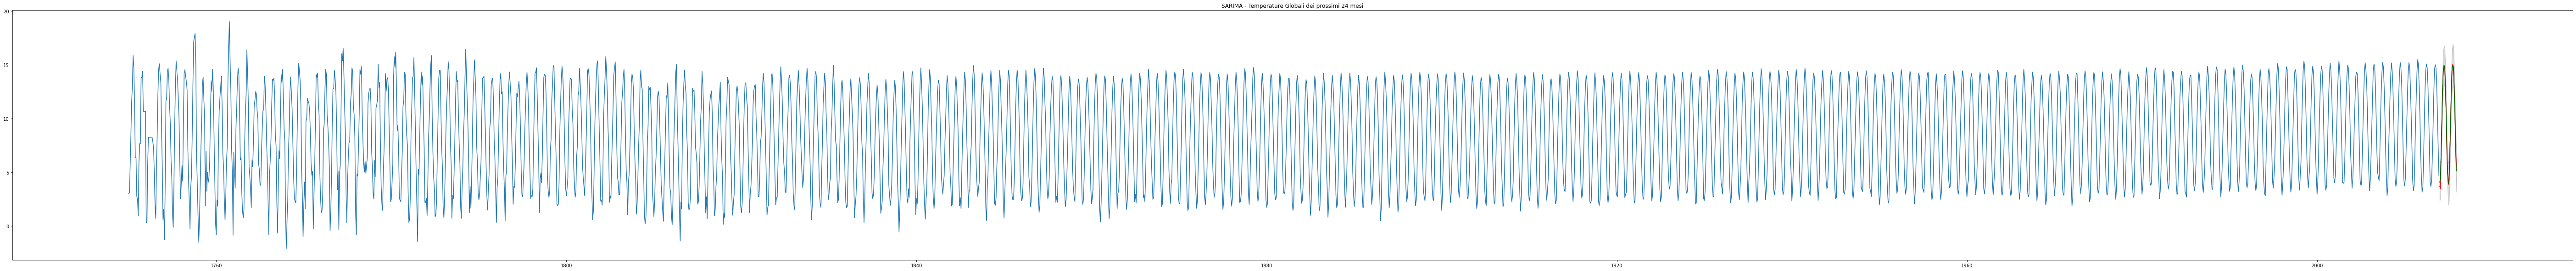

In [63]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(past.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# plot

plt.plot(past)
plt.plot(future, color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Temperature Globali dei prossimi 24 mesi")
plt.show()

Verifichiamo adesso come le eventuali differenze tra i valori reali e valori preditti.
Creiamo un df contenente appunto valori reali e valori preditti e successivamente per ogni periodo (mese) calcoliamo la differenza

In [135]:
df_fitted_serie = pd.DataFrame({'dt':fitted_series.index, 'LandAverageTemperature':fitted_series.values})

In [136]:
df_fitted_serie['dt'] = df_fitted_serie['dt'] + dt.timedelta(1)
compare = df_fitted_serie.merge(future.reset_index(), on = 'dt')

In [143]:
compare['delta'] = abs(compare['LandAverageTemperature_x'] - compare['LandAverageTemperature_y'])

(<AxesSubplot:>,
            delta
 count  24.000000
 mean    0.211616
 std     0.186601
 min     0.003841
 25%     0.078546
 50%     0.156874
 75%     0.295126
 max     0.795550)

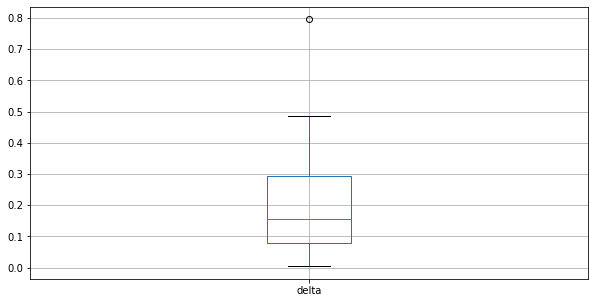

In [158]:
compare[['delta']].boxplot(figsize=(10,5)), compare[['delta']].describe()

La maggior parte dei casi sembrano avere un errore compreso da 0.1 e 0.2

### Predizione delle temperature dei prossimi 10 anni
Si calcolano i successivi 10 anni di temperature, considerando che un anno ha 12 mesi e il _periodo_ nel nostro dataframe è uguale a 1 mese allora il numero di periodi ricercato è 12 * 10 = 120

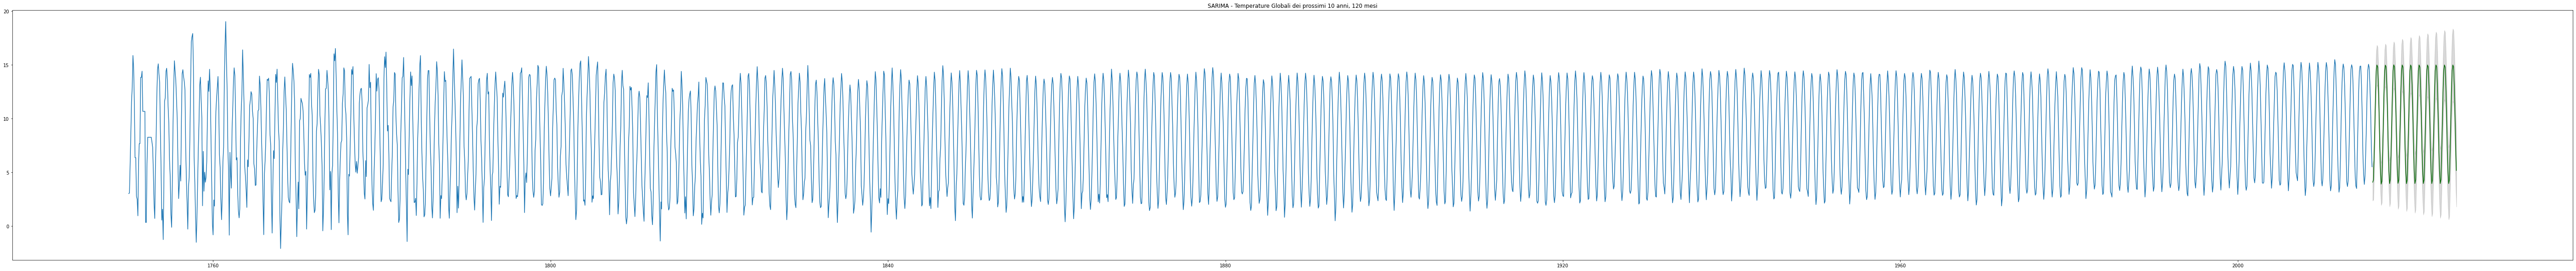

In [173]:
n_periods = 12 * 10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='M')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# plot

plt.plot(data)
#plt.plot(future, color='red')

plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Temperature Globali dei prossimi 10 anni, 120 mesi")
plt.show()

In [174]:
df_fitted_serie = pd.DataFrame({'dt':fitted_series.index, 'LandAverageTemperature':fitted_series.values}).set_index('dt')
df_fitted_serie

LandAverageTemperature
dt                                
2015-12-31                4.088679
2016-01-31                4.295550
2016-02-29                6.517846
2016-03-31                9.295591
2016-04-30               12.319733
...                            ...
2025-07-31               14.800384
2025-08-31               13.062980
2025-09-30               10.571764
2025-10-31                7.199832
2025-11-30                5.176455

[120 rows x 1 columns]

In [177]:
df_fitted_serie_y = df_fitted_serie.groupby(pd.Grouper(freq="Y")).mean()

In [188]:
df_fitted_serie_y.describe(), df_y.describe()

(       LandAverageTemperature
 count               11.000000
 mean                 9.262932
 std                  1.723436
 min                  4.088679
 25%                  9.719634
 50%                  9.729978
 75%                  9.732805
 max                 10.255412,
        LandAverageTemperature
 count              266.000000
 mean                 8.375063
 std                  0.577164
 min                  6.362667
 25%                  8.086750
 50%                  8.380667
 75%                  8.704167
 max                  9.831000)

Le temperature predette sembrano essere coerenti con le temperature presenti nel dataset
